In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from urllib.request import urlopen
import json
from credentials import *
from entsoe import EntsoePandasClient
from entsoe.mappings import lookup_area
from pycaret.time_series import *
import logging

mpl.rcParams['figure.dpi'] = 150
logging.disable(logging.CRITICAL)


### Loading and Joining Datasets

In [119]:
# Get weather data from Open Meteo API
# Setting the coordinates of the Tico Wind Farm
# Located in Villar de los Navarros, Spain

lat = str(41.1585853)
lon = str(-1.045511)

url = 'https://api.open-meteo.com/v1/forecast?' + \
      'latitude=' + lat + \
      '&longitude=' + lon + \
      '&hourly=temperature_2m,pressure_msl,surface_pressure,direct_radiation,evapotranspiration,vapor_pressure_deficit,windspeed_10m,windspeed_80m,windspeed_120m,winddirection_10m,winddirection_80m,winddirection_120m,windgusts_10m&past_days=60'
response = urlopen(url)
data_json = json.loads(response.read())

df_weather = pd.DataFrame(data_json['hourly'])
df_weather.set_index(pd.DatetimeIndex(pd.to_datetime(df_weather['time'])), inplace = True)
df_weather.head()

,time,temperature_2m,pressure_msl,surface_pressure,direct_radiation,evapotranspiration,vapor_pressure_deficit,windspeed_10m,windspeed_80m,windspeed_120m,winddirection_10m,winddirection_80m,winddirection_120m,windgusts_10m
time,,,,,,,,,,,,,,
2022-06-12 00:00:00,2022-06-12T00:00,19.2,NaN,NaN,0.0,0.01,0.87,7.3,7.7,8.1,259.0,298.0,302.0,16.9
2022-06-12 01:00:00,2022-06-12T01:00,18.7,NaN,NaN,0.0,0.01,0.72,6.1,7.9,10.2,267.0,321.0,321.0,13.3
2022-06-12 02:00:00,2022-06-12T02:00,18.4,NaN,NaN,0.0,-0.00,0.59,5.6,6.1,7.9,255.0,320.0,321.0,11.2
2022-06-12 03:00:00,2022-06-12T03:00,17.2,NaN,NaN,0.0,-0.00,0.47,6.3,3.8,4.6,239.0,311.0,321.0,11.2
2022-06-12 04:00:00,2022-06-12T04:00,16.4,NaN,NaN,0.0,-0.00,0.43,6.4,2.1,2.6,232.0,301.0,344.0,11.2


In [53]:
# Get electricity generation per power plant from ENTSO-E API
# Specifying wind onshore generation for Spain
# To get data for the Tico wind farma

country_code = 'ES'
area = lookup_area(country_code)

client = EntsoePandasClient(api_key=get_token())
end = pd.Timestamp.now(tz=area.tz) # - pd.DateOffset(days=10)
start = end - pd.DateOffset(days = 60)
#%time df_energy = client.query_generation(area, start=start,end=end, nett = True, psr_type=None)
%time df_energy = client.query_generation_per_plant(country_code, start=start, end=end, psr_type='B19', include_eic = True)
df_energy.set_index(df_energy.index.tz_convert(None), inplace = True)
df_energy = df_energy.resample('H').mean()


Wall time: 3min 36s


NoMatchingDataError: between 2022-08-11 22:00:28+02:00 and 2022-08-11 22:00:28.766658+02:00


In [76]:
df_energy.columns = df_energy.columns.get_level_values(0)

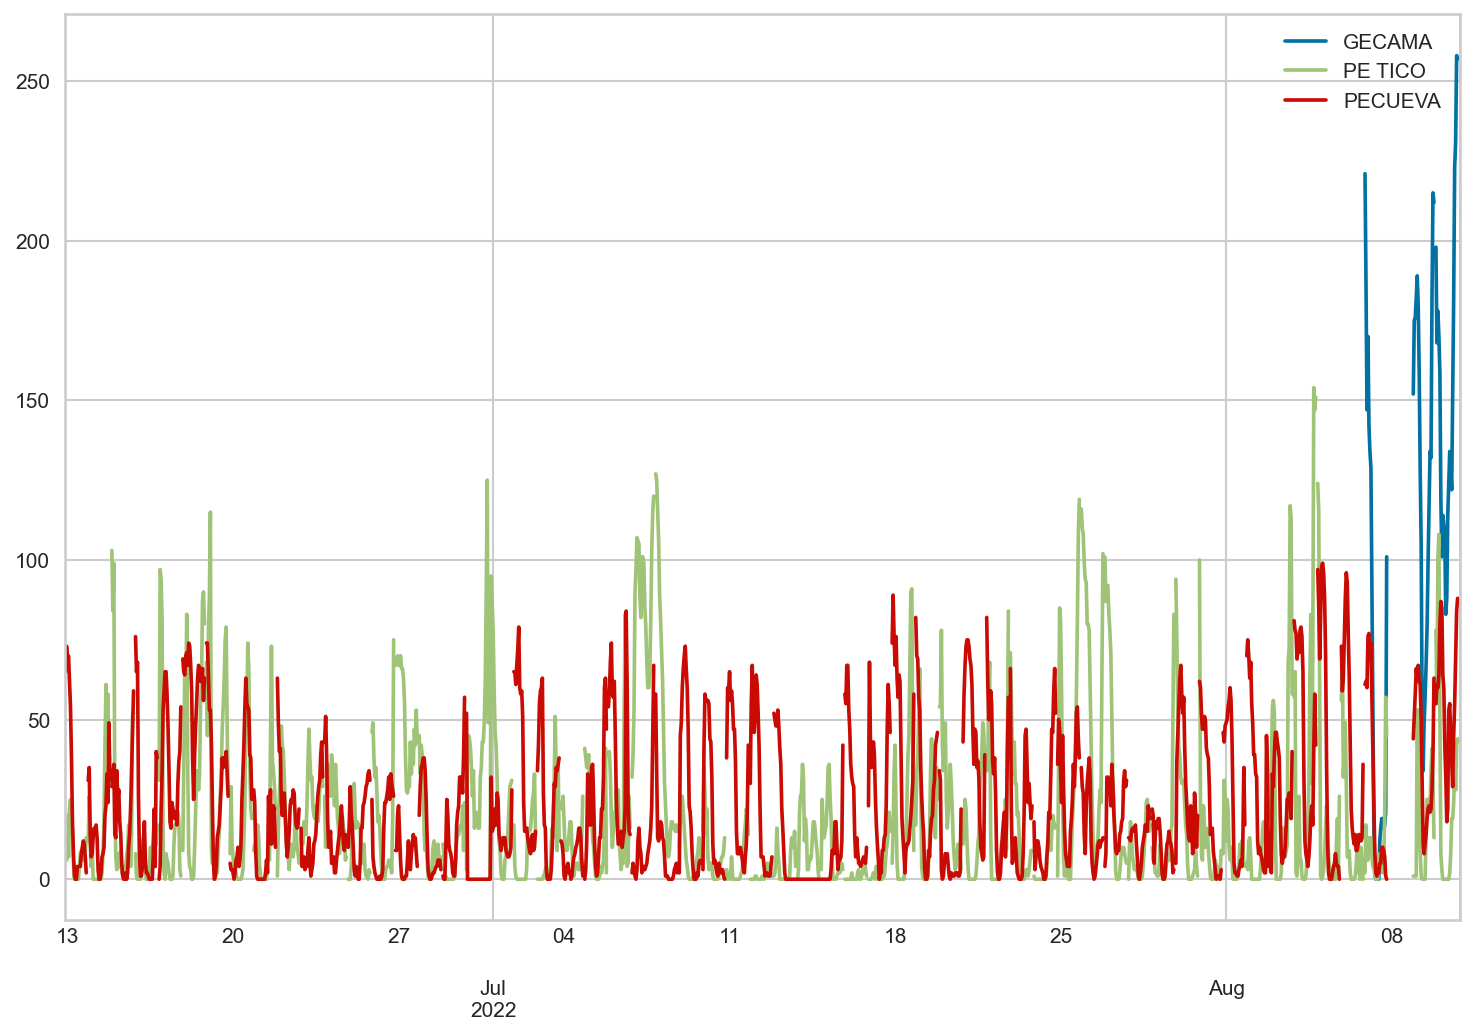

In [88]:
df_energy.plot(figsize = (12,8))
plt.show()

In [145]:
df_energy = df_energy[['PE TICO']].interpolate()

In [160]:
df_energy = df_energy.loc['2022-7']

In [161]:
# Join energy and weather data

df_join = df_energy.join(df_weather, how = 'inner')

df_join.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2022-07-01 00:00:00 to 2022-07-31 23:00:00
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PE TICO                 744 non-null    float64
 1   time                    744 non-null    object 
 2   temperature_2m          744 non-null    float64
 3   pressure_msl            744 non-null    float64
 4   surface_pressure        744 non-null    float64
 5   direct_radiation        744 non-null    float64
 6   evapotranspiration      744 non-null    float64
 7   vapor_pressure_deficit  744 non-null    float64
 8   windspeed_10m           744 non-null    float64
 9   windspeed_80m           744 non-null    float64
 10  windspeed_120m          744 non-null    float64
 11  winddirection_10m       744 non-null    float64
 12  winddirection_80m       744 non-null    float64
 13  winddirection_120m      744 non-null    float64
 14  windg

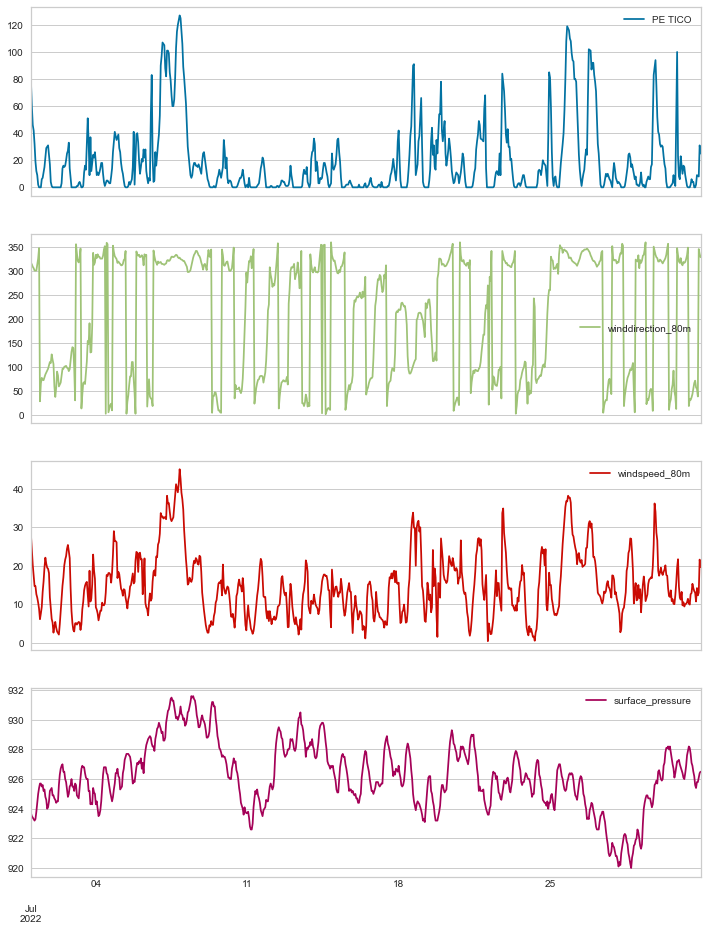

In [162]:
columns = ['PE TICO', 'winddirection_80m', 'windspeed_80m', 'surface_pressure']

df_join[columns].plot(subplots = True, figsize = (12, 16))
plt.show()

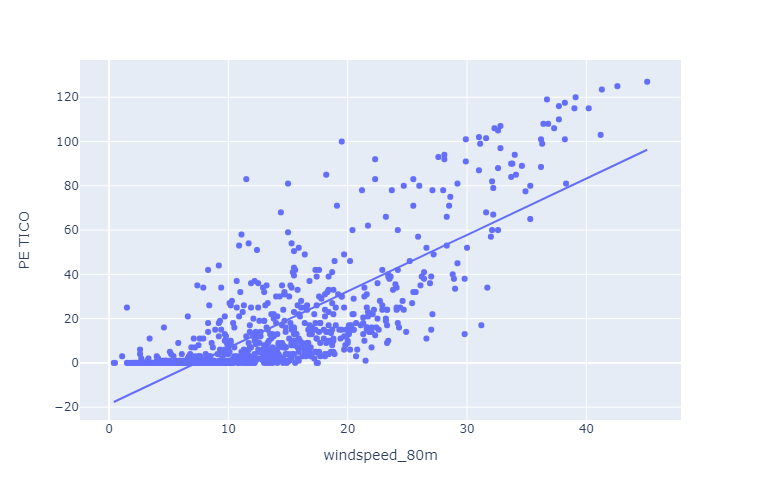

In [163]:
df_join.plot(kind = 'scatter', y = 'PE TICO', x = 'windspeed_80m',
             backend = 'plotly', height = 500, trendline = 'ols')

In [164]:
df_join.corr()

,PE TICO,temperature_2m,pressure_msl,surface_pressure,direct_radiation,evapotranspiration,vapor_pressure_deficit,windspeed_10m,windspeed_80m,windspeed_120m,winddirection_10m,winddirection_80m,winddirection_120m,windgusts_10m
PE TICO,1.000000,-0.269636,0.260660,0.102803,-0.243505,-0.163091,-0.226203,0.611549,0.782493,0.812172,0.308378,0.318013,0.322816,0.640661
temperature_2m,-0.269636,1.000000,-0.578706,0.077850,0.641606,0.619819,0.955802,0.169621,-0.022164,-0.113207,-0.616673,-0.614595,-0.617850,0.198625
pressure_msl,0.260660,-0.578706,1.000000,0.767827,-0.191096,-0.094566,-0.535395,0.023824,0.115706,0.161791,0.455476,0.455845,0.463292,-0.014077
surface_pressure,0.102803,0.077850,0.767827,1.000000,0.270917,0.371889,0.093001,0.159742,0.120717,0.105454,0.072822,0.074431,0.080902,0.135733
direct_radiation,-0.243505,0.641606,-0.191096,0.270917,1.000000,0.901105,0.598596,0.329677,0.016072,-0.109198,-0.458284,-0.420713,-0.409810,0.277709
evapotranspiration,-0.163091,0.619819,-0.094566,0.371889,0.901105,1.000000,0.571107,0.338429,0.051298,-0.072880,-0.435243,-0.398072,-0.387066,0.305711
vapor_pressure_deficit,-0.226203,0.955802,-0.535395,0.093001,0.598596,0.571107,1.000000,0.162676,-0.004368,-0.085192,-0.553957,-0.540390,-0.543591,0.187289
windspeed_10m,0.611549,0.169621,0.023824,0.159742,0.329677,0.338429,0.162676,1.000000,0.893556,0.809123,-0.005942,0.026414,0.029136,0.946821
windspeed_80m,0.782493,-0.022164,0.115706,0.120717,0.016072,0.051298,-0.004368,0.893556,1.000000,0.981506,0.176949,0.184035,0.190283,0.902683
windspeed_120m,0.812172,-0.113207,0.161791,0.105454,-0.109198,-0.072880,-0.085192,0.809123,0.981506,1.000000,0.245634,0.245021,0.250238,0.836720


In [165]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2022-07-01 00:00:00 to 2022-07-31 23:00:00
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PE TICO                 744 non-null    float64
 1   time                    744 non-null    object 
 2   temperature_2m          744 non-null    float64
 3   pressure_msl            744 non-null    float64
 4   surface_pressure        744 non-null    float64
 5   direct_radiation        744 non-null    float64
 6   evapotranspiration      744 non-null    float64
 7   vapor_pressure_deficit  744 non-null    float64
 8   windspeed_10m           744 non-null    float64
 9   windspeed_80m           744 non-null    float64
 10  windspeed_120m          744 non-null    float64
 11  winddirection_10m       744 non-null    float64
 12  winddirection_80m       744 non-null    float64
 13  winddirection_120m      744 non-null    float64
 14  windg

### Forecasting with PyCaret

In [187]:
columns = ['PE TICO', 'windspeed_80m']

ts = setup(data = df_join[columns], target = 'PE TICO',
           numeric_imputation_exogenous = 'linear',
           fh = 6, enforce_exogenous = True, fold = 3)
           

,Description,Value
0,session_id,689
1,Target,PE TICO
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(744, 2)"
5,Transformed data shape,"(744, 2)"
6,Transformed train set shape,"(738, 2)"
7,Transformed test set shape,"(6, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [188]:
compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,0.2687,0.1896,5.4800,6.1309,9415349794550254.0000,0.9540,-2.1134,4.3567
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.2855,0.2323,5.8086,7.4977,12285698471135210.0000,0.8769,-13.6859,0.5767
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.2987,0.2427,6.0782,7.8352,13073518319212310.0000,0.8995,-14.3503,0.5467
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.3023,0.2100,6.1662,6.7886,10538462053519278.0000,0.9637,-3.3795,0.8800
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.3045,0.2436,6.1994,7.8670,10741103313615630.0000,0.9979,-10.8113,0.5333
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.3130,0.2522,6.3703,8.1395,13724687841884192.0000,0.9562,-15.0853,0.5600
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.3303,0.2651,6.7228,8.5558,14079331928346390.0000,0.9995,-16.1829,0.5633
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.3304,0.2651,6.7231,8.5561,14079537018198360.0000,0.9995,-16.1836,0.5367
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.3369,0.2431,6.8703,7.8594,12883479150097650.0000,1.2423,-4.4152,0.5800
auto_arima,Auto ARIMA,0.3847,0.2803,7.8423,9.0585,17626717673648180.0000,0.9686,-8.4276,20.0033


Processing:   0%|          | 0/93 [00:00<?, ?it/s]

BaseCdsDtForecaster(regressor=<catboost.core.CatBoostRegressor object at 0x00000238D4E030C8>,
                    sp=24, window_length=24)

In [169]:
model = create_model('auto_arima', engine = 'statsforecast')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-07-27 23:00,0.2587,0.1842,5.2593,5.9744,5708683660556627.0000,0.7857,0.3889
1,2022-07-28 23:00,0.8705,0.8896,17.7469,28.8955,3001592132724873.5000,1.0175,0.1445
2,2022-07-29 23:00,0.6089,0.6500,12.3831,21.1203,12199215970429528.0000,0.8799,0.1338
Mean,NaT,0.5794,0.5746,11.7964,18.6634,6969830587903676.0000,0.8944,0.2224
SD,NaT,0.2506,0.2929,5.1149,9.5174,3859355709981127.5000,0.0952,0.1178


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

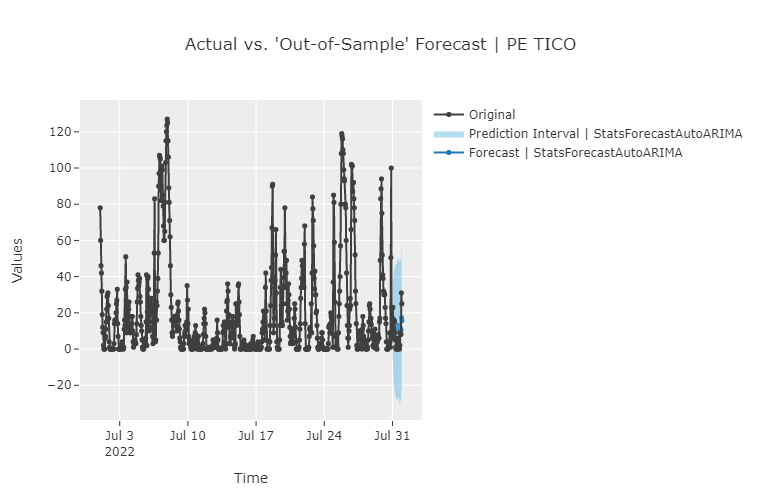

In [183]:
fig_kwargs={'renderer': 'jupyterlab', 'height': 500}
plot_model(model, fig_kwargs = fig_kwargs)

In [128]:
df_join['PE TICO']

2022-06-12 21:00:00    13.0
2022-06-12 22:00:00    15.0
2022-06-12 23:00:00     6.0
2022-06-13 00:00:00    20.0
2022-06-13 01:00:00     7.0
                       ... 
2022-08-10 17:00:00    28.0
2022-08-10 18:00:00    42.0
2022-08-10 19:00:00    44.0
2022-08-10 20:00:00     NaN
2022-08-10 21:00:00    24.0
Name: PE TICO, Length: 1417, dtype: float64